In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True

/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 학습을 위해 데이터 증가(augmentation) 및 일반화(normalization)
# 검증을 위한 일반화
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 데이터셋 위치
data_dir = '../dataset/fruit_fresh_and_rotten_dataset/'

# 데이터셋 정제
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

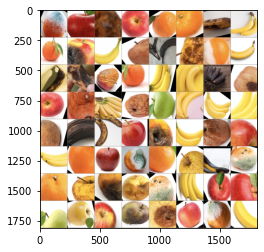

['rottenoranges', 'freshapples', 'rottenoranges', 'freshapples', 'freshoranges', 'freshoranges', 'rottenbanana', 'freshbanana', 'freshoranges', 'rottenapples', 'freshbanana', 'rottenapples', 'rottenbanana', 'rottenapples', 'rottenoranges', 'freshbanana', 'rottenbanana', 'rottenbanana', 'rottenapples', 'freshoranges', 'freshbanana', 'freshbanana', 'rottenbanana', 'rottenapples', 'freshapples', 'rottenapples', 'freshbanana', 'rottenapples', 'freshapples', 'freshbanana', 'freshbanana', 'freshbanana', 'rottenapples', 'rottenbanana', 'rottenbanana', 'freshapples', 'rottenapples', 'freshbanana', 'rottenapples', 'freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenoranges', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges', 'freshoranges', 'rottenapples', 'rottenoranges', 'rottenapples', 'rottenoranges', 'freshbanana', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'rottenapples', 'rottenapples', 'freshapples', 'rottenoranges', 'freshb

In [3]:
# transform 된 배치 이미지 시각화
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out)
print([class_names[x] for x in classes])

In [4]:
# 미리 학습된 resnet 모델 불러오기
model_ft = models.resnet18(pretrained=True)
# model_ft = model_ft.to(device)

# 마지막 연결계층의 입력부분까지 받아오기 > 완전계층 이후 부분은 학습
num_ftrs = model_ft.fc.in_features
# 여기서 각 출력 샘플의 크기는 2로 설정합니다.
# 또는, nn.Linear(num_ftrs, len (class_names))로 일반화할 수 있습니다.
model_ft.fc = nn.Linear(num_ftrs, 6)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    model = model.to(device)
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())      # 모델 학습파라미터 불러와서 카피
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 배치크기로 반복해서 불러옴
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 모델을 깊은 복사(deep copy)함, 값 갱신
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

In [6]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------
train Loss: 0.4539 Acc: 0.8627
val Loss: 0.0899 Acc: 0.9763

Epoch 1/19
----------
train Loss: 0.1260 Acc: 0.9605
val Loss: 0.0404 Acc: 0.9907

Epoch 2/19
----------
train Loss: 0.0889 Acc: 0.9719
val Loss: 0.0247 Acc: 0.9959

Epoch 3/19
----------
train Loss: 0.0718 Acc: 0.9775
val Loss: 0.0213 Acc: 0.9956

Epoch 4/19
----------
train Loss: 0.0630 Acc: 0.9810
val Loss: 0.0142 Acc: 0.9974

Epoch 5/19
----------
train Loss: 0.0545 Acc: 0.9823
val Loss: 0.0129 Acc: 0.9978

Epoch 6/19
----------
train Loss: 0.0528 Acc: 0.9837
val Loss: 0.0101 Acc: 0.9981

Epoch 7/19
----------
train Loss: 0.0449 Acc: 0.9862
val Loss: 0.0087 Acc: 0.9989

Epoch 8/19
----------
train Loss: 0.0446 Acc: 0.9865
val Loss: 0.0081 Acc: 0.9993

Epoch 9/19
----------
train Loss: 0.0448 Acc: 0.9845
val Loss: 0.0076 Acc: 0.9985

Epoch 10/19
----------
train Loss: 0.0446 Acc: 0.9845
val Loss: 0.0073 Acc: 0.9989

Epoch 11/19
----------
train Loss: 0.0422 Acc: 0.9848
val Loss: 0.0077 Acc: 0.9985

Ep